In [18]:
from __future__ import annotations
import numpy as np
import pandas as pd
from typing import Optional, Tuple, Union, Sequence, List
from abc import ABC, abstractmethod
import matplotlib.pyplot as plt

class BaseSAAdapter(ABC):
    @abstractmethod
    def fit(self, X, y, time_col: str = "time", event_col: str = "event"): ...
    @abstractmethod
    def predict_survival_function(self, X, times: Optional[Sequence[float]] = None): ...
    @abstractmethod
    def predict_hazard_function(self, X, times: Optional[Sequence[float]] = None): ...
    @abstractmethod
    def predict_time(self,X): ...
    @abstractmethod
    def predict_proba(self, X): ...
    
    def timeWrap(self, y, time_col="time", event_col="event"):
        if isinstance(y, tuple) and len(y) == 2:
            t, e = y
            return np.asarray(t, float), np.asarray(e, bool)
        if isinstance(y, pd.DataFrame):
            return y[time_col].to_numpy(dtype=float), y[event_col].to_numpy(dtype=bool)
        if isinstance(y, dict):
            return np.asarray(y[time_col], float), np.asarray(y[event_col], bool)
        if isinstance(y, np.ndarray) and y.dtype.names:
            names = list(y.dtype.names)
            ev = next((n for n in names if n.lower().startswith(("event", "status"))), names[0])
            tm = next((n for n in names if n.lower().startswith(("time", "duration"))), names[-1])
            return y[tm].astype(float), y[ev].astype(bool)
        raise ValueError("Unsupported y format")
    
    @staticmethod
    def _has(obj, name): return hasattr(obj, name)

    def _get_proba(self, model, X) -> np.ndarray:
        if self._has(model, "predict_proba"):
            proba = model.predict_proba(X)
            if proba.ndim == 2 and proba.shape[1] >= 2:
                return proba[:, 1]
            return np.clip(np.ravel(proba), 0.0, 1.0)
        if self._has(model, "decision_function"):
            z = np.asarray(model.decision_function(X), float).ravel()
            return 1.0 / (1.0 + np.exp(-z))
        if self._has(model, "predict"):
            yhat = np.asarray(model.predict(X))
            if set(np.unique(yhat)).issubset({0, 1, False, True}):
                return yhat.astype(float)
            ymin, ymax = float(np.min(yhat)), float(np.max(yhat))
            if ymax > ymin:
                return np.clip((yhat - ymin) / (ymax - ymin), 0.0, 1.0)
            return np.zeros_like(yhat, dtype=float)
        n = len(X) if hasattr(X, "__len__") else 1
        return np.full(n, 0.5, float)


class ClassifWrapSA(BaseSAAdapter):
    def __init__(self, model, times: int = 128, start_at_zero: bool = True):
        self.model = model
        self.times = times
        self.start_at_zero = start_at_zero
        self._bounds: Optional[Tuple[float, float]] = None
    def fit(self, X, y, time_col: str = "time", event_col: str = "event"):
        t, e = self.timeWrap(y, time_col, event_col)
        left = float(np.min(t))
        right = float(np.max(t))
        if not np.isfinite(left) or not np.isfinite(right) or left >= right:
            left = 0.0
            right = 1.0
        self._bounds = (left, right)
        self.model.fit(X, e.astype(int))
        return self
    def predict_proba(self, X):
        proba = self._get_proba(self.model, X)
        if proba.ndim == 1:
            proba = np.column_stack([1 - proba, proba])
        return proba
    def predict_survival_function(self, X, times = None):
        assert self._bounds is not None, "Call fit() first"
        if times is not None:
            t = np.asarray(times, float)
        else:
            left, right = self._bounds
            start = 0.0 if self.start_at_zero else left
            t = np.linspace(start, right, self.times) #разбивает на равномерную сетку
        p = self._get_proba(self.model, X)
        S = np.tile((1.0-p)[:, None], (1,t.size)) #матрица выживаемости dim(p)*t.size
        return S, t
    def predict_hazard_function(self, X, times=None):
        S, t = self.predict_survival_function(X, times)
        eps = 1e-12
        H = -np.log(np.clip(S, eps, 1.0))   # кумулятивная hazard, константна по t
        return H, t

    def predict_time(self, X):
        n = len(X) if hasattr(X, "__len__") else self.predict_proba(X).shape[0]
        return np.full(n, np.nan, float)
class RegrWrapSA(BaseSAAdapter):
    def __init__(self, model, times: int = 128, start_at_zero: bool = True):
        self.model = model
        self.times = times
        self.start_at_zero = start_at_zero
        self._bounds: Optional[Tuple[float, float]] = None
    def fit(self, X, y, time_col: str = "time", event_col: str = "event"):
        t, _ = self.timeWrap(y, time_col, event_col)
        left = float(np.min(t))
        right = float(np.max(t))
        if not np.isfinite(left) or not np.isfinite(right) or left >= right:
            left = 0.0
            right = 1.0
        self._bounds = (left, right)
        self.model.fit(X, t.astype(float))
        return self
    def predict_time(self, X):
        return np.asarray(self.model.predict(X), float)
    def predict_survival_function(self, X, times = None):
        assert self._bounds is not None, "Call fit() first"
        if times is not None:
            t = np.asarray(times, float)
        else:
            left, right = self._bounds
            start = 0.0 if self.start_at_zero else left
            t = np.linspace(start, right, self.times) #разбивает на равномерную сетку
        T = self.predict_time(X)[:, None]
        S = (t[None, :] < T).astype(float)
        return S, t
    def predict_hazard_function(self, X, times = None):
        S, t = self.predict_survival_function(X, times)
        eps = 1e-12
        H = -np.log(np.clip(S, eps, 1.0))  # кумулятивная hazard
        return H, t
    def predict_proba(self, X):
        S, _ = self.predict_survival_function(X)
        p = 1.0 - S[:, -1]
        return np.column_stack([1.0 - p, p])
class SAWrapSA(BaseSAAdapter):
    def __init__(self, model, times: int = 128, start_at_zero: bool = True):
        self.model = model
        self.times = times
        self.start_at_zero = start_at_zero
        self._bounds: Optional[Tuple[float, float]] = None
        self._kind = model.__class__.__module__
    @staticmethod
    def _make_structured_y(t, e):
        return np.array(list(zip(e.astype(bool), t.astype(float))), dtype=[('event','?'),('time','<f8')])
    
    def fit(self, X, y, time_col: str = "time", event_col: str = "event"):
        t, e = self.timeWrap(y, time_col, event_col)
        left = float(np.min(t))
        right = float(np.max(t))
        if not np.isfinite(left) or not np.isfinite(right) or left >= right:
            left = 0.0
            right = 1.0
        self._bounds = (left, right)
        if "lifelines" in self._kind:
            df = pd.DataFrame(X if isinstance(X, pd.DataFrame) else np.asarray(X)).copy()
            df[time_col] = t
            df[event_col] = e.astype(int)
            self.model.fit(df, duration_col=time_col, event_col=event_col)
        elif self._kind.startswith("sksurv.") or "sksurv" in self._kind:
            self.model.fit(X, self._make_structured_y(t, e))
        elif "survivors" in self._kind:
            self.model.fit(X, y)
        else:
            self.model.fit(X, y)
        return self
    def predict_survival_function(self, X, times = None):
        assert self._bounds is not None, "Call fit() first"
        if times is not None:
            t = np.asarray(times, float)
        else:
            left, right = self._bounds
            start = 0.0 if self.start_at_zero else left
            t = np.linspace(start, right, self.times) #разбивает на равномерную сетку
        if "lifelines" in self._kind:
            df = X if isinstance(X, pd.DataFrame) else pd.DataFrame(X)
            sf = self.model.predict_survival_function(df)
            if isinstance(sf, list):
                S = np.vstack([np.interp(t, s.index.values.astype(float), np.asarray(s).astype(float)) for s in sf])
            else:
                idx = sf.index.values.astype(float)
                S = np.vstack([np.interp(t, idx, sf.iloc[:, i].values.astype(float)) for i in range(sf.shape[1])])
            return S, t
        elif self._kind.startswith("sksurv.") or "sksurv" in self._kind:
            s = self.model.predict_survival_function(X)
            S = np.vstack([sf(t) for sf in s])
            return S, t
        elif "survivors" in self._kind:
            if times is not None:
                t = np.asarray(times, float)
            else:
                left, right = self._bounds
                start = 0.0 if self.start_at_zero else left
                t = np.linspace(start, right, self.times)
            S = np.asarray(self.model.predict_at_times(X, t, mode="surv"), float)
            if S.ndim == 1:
                S = S[None, :]
            elif S.shape[1] != t.shape[0] and S.shape[0] == t.shape[0]:
                S = S.T
            return S, t


        raise RuntimeError("Model does not provide survival predictions")
        
    def predict_hazard_function(self, X, times = None):
        assert self._bounds is not None, "Call fit() first"
        if "lifelines" in self._kind and hasattr(self.model, "predict_cumulative_hazard"):
            if times is not None:
                t = np.asarray(times, float)
            else:
                left, right = self._bounds
                start = 0.0 if self.start_at_zero else left
                t = np.linspace(start, right, self.times) #разбивает на равномерную сетку
            df = X if isinstance(X, pd.DataFrame) else pd.DataFrame(X)
            ch = self.model.predict_cumulative_hazard(df)
            if isinstance(ch, list):
                H = np.vstack([np.interp(t, h.index.values.astype(float), np.asarray(h).astype(float)) for h in ch])
            else:
                idx = ch.index.values.astype(float)
                H = np.vstack([np.interp(t, idx, ch.iloc[:, i].values.astype(float)) for i in range(ch.shape[1])])
            return H, t
        if "survivors" in self._kind:
            if times is not None:
                t = np.asarray(times, float)
            else:
                left, right = self._bounds
                start = 0.0 if self.start_at_zero else left
                t = np.linspace(start, right, self.times)
            H = np.asarray(self.model.predict_at_times(X, t, mode="hazard"), float)
            if H.ndim == 1:
                H = H[None, :]
            elif H.shape[1] != t.shape[0] and H.shape[0] == t.shape[0]:
                H = H.T
            return H, t

        S, t = self.predict_survival_function(X, times) #для всех других моделей
        eps = 1e-12
        H = -np.log(np.clip(S, eps, 1.0))
        return H, t
    
    def predict_time(self, X):
        S, t = self.predict_survival_function(X)
        med = np.full(S.shape[0], np.nan, float)
        for i, row in enumerate(S):
            j = np.argmax(row <= 0.5)
            if row[j] <= 0.5:
                med[i] = t[j]
        return med
    def predict_proba(self, X):
        S, _ = self.predict_survival_function(X)
        p = 1.0 - S[:, -1]
        return np.column_stack([1.0 - p, p])

def plot_many(models, X, sample: int = 0, times: Optional[Sequence[float]] = None, title="Survival curves comparison", mode: str = "survival"):
    if times is not None:
        t_common = np.asarray(times, float)
    else:
        t_max = 1.0
        for m in models:
            if m._bounds is not None:
                t_max = max(t_max, m._bounds[1])
        t_common = np.linspace(0.0, t_max, 128)
    X_i = X.iloc[[sample]] if isinstance(X, pd.DataFrame) else np.asarray(X)[[sample], :]
    plt.figure(figsize=(7, 5))
    for m in models:
        name = type(m.model).__name__
        if mode.lower().startswith("h"):
            S, _ = m.predict_hazard_function(X_i, t_common)
            ylabel = "Hazard H(t)"
        else:
            S, _ = m.predict_survival_function(X_i, t_common)
            ylabel = "Survival S(t)"
        plt.plot(t_common, S[0], label=name)
    plt.xlabel("Time")
    plt.ylabel("Survival S(t)")
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.show()
    




In [19]:
X = pd.DataFrame({"age":[60,55,70,50], "stage":[2,1,3,2]})
time  = np.array([5, 7, 3, 12], float)
event = np.array([1, 0, 1,  1], bool)
y = (time, event)

d:\Users\DimonZhi\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


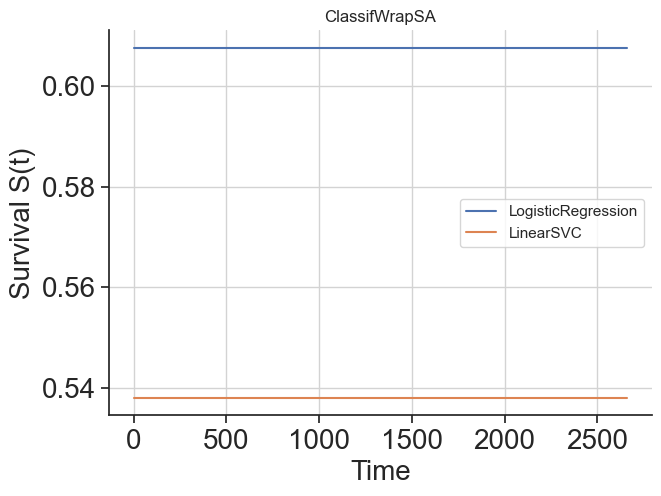

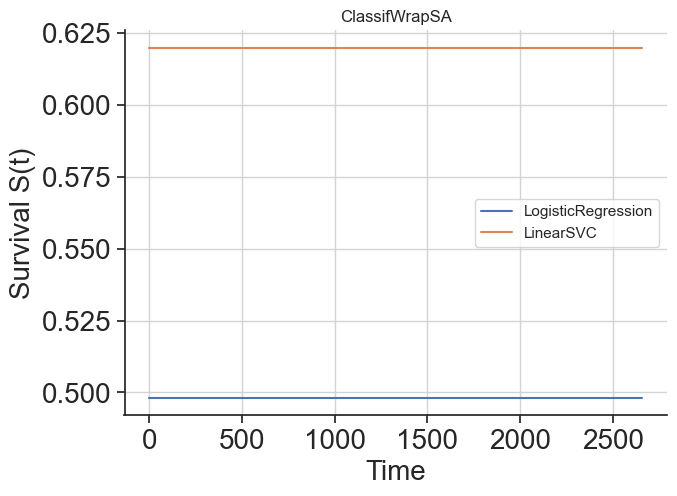

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
m_cls1 = ClassifWrapSA(LogisticRegression()).fit(X, y)
m_cls2 = ClassifWrapSA(LinearSVC()).fit(X, y)
plot_many([m_cls1, m_cls2], X, sample=0, title="ClassifWrapSA")
plot_many([m_cls1, m_cls2], X, sample=0, title="ClassifWrapSA", mode="hazard")

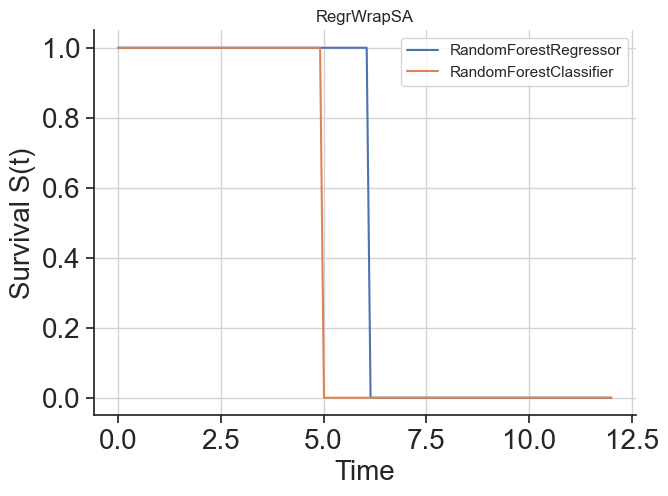

In [21]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
m_reg1 = RegrWrapSA(RandomForestRegressor()).fit(X, y)
m_reg2 = RegrWrapSA(RandomForestClassifier()).fit(X, y)
plot_many([m_reg1, m_reg2], X, sample=0, title="RegrWrapSA")

d:\Users\DimonZhi\anaconda3\Lib\site-packages\lifelines\utils\__init__.py:1163: ConvergenceWarning: Column age has high sample correlation with the duration column. This may harm convergence. This could be a form of 'complete separation'.     See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression

  warnings.warn(dedent(warning_text), ConvergenceWarning)
d:\Users\DimonZhi\anaconda3\Lib\site-packages\lifelines\fitters\coxph_fitter.py:1607: ConvergenceWarning: Newton-Raphson convergence completed successfully but norm(delta) is still high, 0.946. This may imply non-unique solutions to the maximum likelihood. Perhaps there is collinearity or complete separation in the dataset?

  warnings.warn(


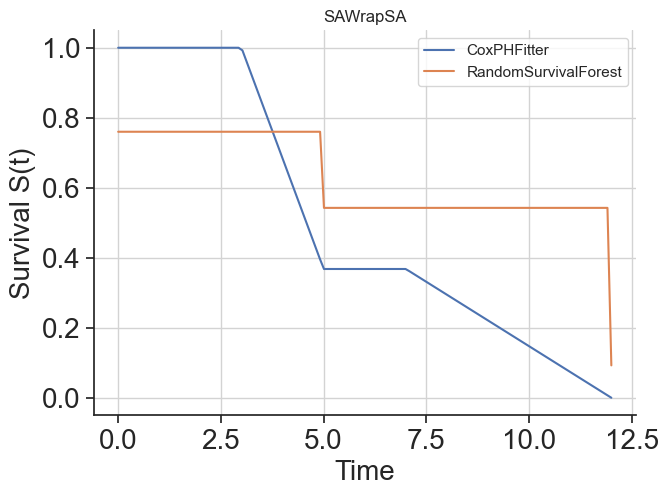

In [22]:
from lifelines import CoxPHFitter
from sksurv.ensemble import RandomSurvivalForest
m_sa1 = SAWrapSA(CoxPHFitter()).fit(X, y)
m_sa2 = SAWrapSA(RandomSurvivalForest(n_estimators=100, random_state=0)).fit(X, y)
plot_many([m_sa1, m_sa2], X, sample=0, title="SAWrapSA")

In [23]:
from metrics_sa import eval_model_proba, cindex, print_metrics

metrics = eval_model_proba(m_sa1, X, event)
print_metrics(metrics, "CoxPHFitter")
metrics = eval_model_proba(m_sa2, X, event)
print_metrics(metrics, "RandomSurvivalForest")

CoxPHFitter
accuracy: 0.7500
roc_auc: 0.6667
f1_score: 0.8571
log_loss: 0.4425
brier_score: 0.1673
c_index: 0.6667
RandomSurvivalForest
accuracy: 0.7500
roc_auc: 0.5000
f1_score: 0.8571
log_loss: 0.6679
brier_score: 0.2123
c_index: 0.5000


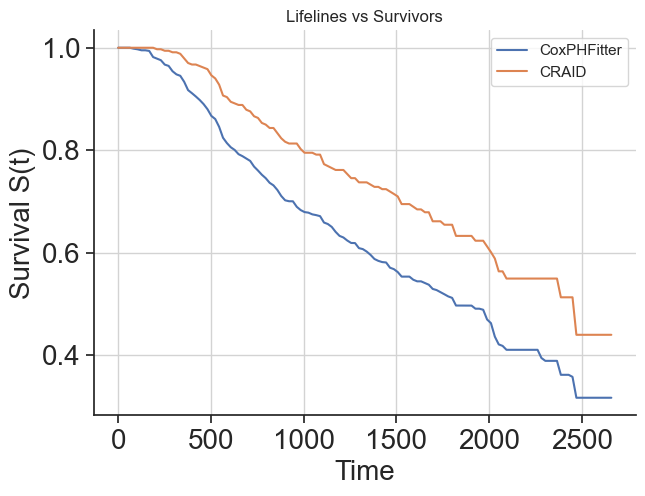

In [24]:
from lifelines import CoxPHFitter
import survivors.datasets as ds
from survivors.tree import CRAID

X, y, features, categ, sch_nan = ds.load_gbsg_dataset()

cr = CRAID(criterion='wilcoxon', depth=2, min_samples_leaf=0.1,
           signif=0.05, categ=categ, leaf_model="base")

m_sa1 = SAWrapSA(CoxPHFitter()).fit(X, y)
m_sa2 = SAWrapSA(cr).fit(X, y)

plot_many([m_sa1, m_sa2], X, sample=0, title="Lifelines vs Survivors")

In [25]:
event = y["cens"]
y_event = event.astype(int)
metrics = eval_model_proba(m_sa1, X, y_event)
print_metrics(metrics, "CoxPHFitter")
metrics = eval_model_proba(m_sa2, X, y_event)
print_metrics(metrics, "CRAID")

CoxPHFitter
accuracy: 0.5350
roc_auc: 0.6842
f1_score: 0.6338
log_loss: 0.8050
brier_score: 0.2782
c_index: 0.6842
CRAID
accuracy: 0.4359
roc_auc: 0.6611
f1_score: 0.6071
log_loss: 0.7456
brier_score: 0.2722
c_index: 0.6611


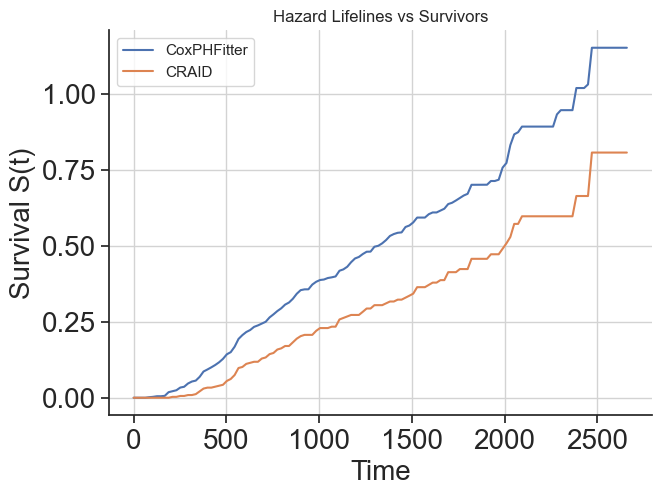

In [26]:
from lifelines import CoxPHFitter
import survivors.datasets as ds
from survivors.tree import CRAID

X, y, features, categ, sch_nan = ds.load_gbsg_dataset()

cr = CRAID(criterion='wilcoxon', depth=2, min_samples_leaf=0.1,
           signif=0.05, categ=categ, leaf_model="base")

m_sa1 = SAWrapSA(CoxPHFitter()).fit(X, y)
m_sa2 = SAWrapSA(cr).fit(X, y)

plot_many([m_sa1, m_sa2], X, sample=0, mode="hazard", title="Hazard Lifelines vs Survivors")